         Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
0  2008-12-01   Albury     13.4     22.9       0.6          NaN       NaN   
1  2008-12-02   Albury      7.4     25.1       0.0          NaN       NaN   
2  2008-12-03   Albury     12.9     25.7       0.0          NaN       NaN   
3  2008-12-04   Albury      9.2     28.0       0.0          NaN       NaN   
4  2008-12-05   Albury     17.5     32.3       1.0          NaN       NaN   

  WindGustDir  WindGustSpeed WindDir9am  ... Humidity9am  Humidity3pm  \
0           W           44.0          W  ...        71.0         22.0   
1         WNW           44.0        NNW  ...        44.0         25.0   
2         WSW           46.0          W  ...        38.0         30.0   
3          NE           24.0         SE  ...        45.0         16.0   
4           W           41.0        ENE  ...        82.0         33.0   

   Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  RainToday  \
0       1007.7    

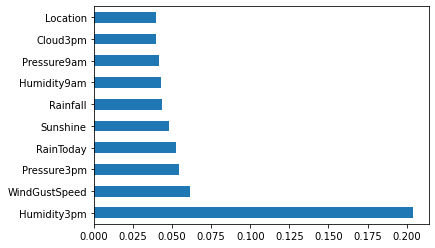

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# %matplotlib inline
from sklearn.metrics import plot_confusion_matrix
import pickle


rain = pd.read_csv("C:\\Users\\Uzair Sufiyan\\Downloads\\weatherAUS.csv")

print(rain.head())
#the head method shows us the first five data rows from csv

#now we check the info of our data in csv
print(rain.info())

# now we see the categorical features in Dataset
categorical_features = [column_name for column_name in rain.columns if rain[column_name].dtype == 'O']
print("Number of Categorical Features: {}".format(len(categorical_features)))
print("Categorical Features: ",categorical_features)

# Numerical Features in Dataset
numerical_features = [column_name for column_name in rain.columns if rain[column_name].dtype != 'O']
print("Number of Numerical Features: {}".format(len(numerical_features)))
print("Numerical Features: ",numerical_features)

#as our model ovly supports numerical data, we need to convert the catagorical data to
#numerical data
#but before that , we chek cardinality (number of unique values in catagorical data)
#then , we need to handle the data that has high cardinality as it may increase dimension of data when encoded

for each_feature in categorical_features:
   unique_values = len(rain[each_feature].unique())
   print("Unique values in {} are: {}".format(each_feature, unique_values))

#as the cardinality of date column is very high, hence we drop it
rain.drop('Date', axis = 1, inplace = True)
rain.head()

#now we need to handle missing values as our ML algo will not be able to handle missing values.The process we will 
#follow is called Missing value imputation
#we will replace it with mod 

#For catagorical features
categorical_features = [column_name for column_name in rain.columns if rain[column_name].dtype == 'O']
rain[categorical_features].isnull().sum()

categorical_features_with_null = [feature for feature in categorical_features if rain[feature].isnull().sum()]
for each_feature in categorical_features_with_null:
    mode_val = rain[each_feature].mode()[0]
    rain[each_feature].fillna(mode_val,inplace=True)

#handling missing values in Numerical faetures
numerical_features = [column_name for column_name in rain.columns if rain[column_name].dtype != 'O']
rain[numerical_features].isnull().sum()

#in case of numerical features , we will impute with mean.....but mean is sensitive to outliers
#hence we remove outliers from our data
features_with_outliers = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'WindGustSpeed','WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Pressure9am', 'Pressure3pm', 'Temp9am', 'Temp3pm']
for feature in features_with_outliers:
    q1 = rain[feature].quantile(0.25)
    q3 = rain[feature].quantile(0.75)
    IQR = q3-q1
    lower_limit = q1 - (IQR*1.5)
    upper_limit = q3 + (IQR*1.5)
    rain.loc[rain[feature]<lower_limit,feature] = lower_limit
    rain.loc[rain[feature]>upper_limit,feature] = upper_limit

#imputing missing data
numerical_features_with_null = [feature for feature in numerical_features if rain[feature].isnull().sum()]
for feature in numerical_features_with_null:
    mean_value = rain[feature].mean()
    rain[feature].fillna(mean_value,inplace=True)

#now we encode the catagorical data so that our ML algo can handle it
def encode_data(feature_name):

    ''' 

    This function takes feature name as a parameter and returns mapping dictionary to replace(or map) categorical data with numerical data.

    '''

    mapping_dict = {}

    unique_values = list(rain[feature_name].unique())

    for idx in range(len(unique_values)):

        mapping_dict[unique_values[idx]] = idx

    return mapping_dict




rain['RainToday'].replace({'No':0, 'Yes': 1}, inplace = True)

rain['RainTomorrow'].replace({'No':0, 'Yes': 1}, inplace = True)

rain['WindGustDir'].replace(encode_data('WindGustDir'),inplace = True)

rain['WindDir9am'].replace(encode_data('WindDir9am'),inplace = True)

rain['WindDir3pm'].replace(encode_data('WindDir3pm'),inplace = True)

rain['Location'].replace(encode_data('Location'), inplace = True)

print(rain.head())

# Splitting data into Independent Features and Dependent Features
X = rain.drop(['RainTomorrow'],axis=1)  #independent
y = rain['RainTomorrow']    #depenedent

#now we will control overfitting by ExtraTreesRegressor
#Feature importance describes which features are relevant to build a model.
from sklearn.ensemble import ExtraTreesRegressor
etr_model = ExtraTreesRegressor()
etr_model.fit(X,y)
etr_model.feature_importances_

#visualizing the data
feature_imp = pd.Series(etr_model.feature_importances_,index=X.columns)
feature_imp.nlargest(10).plot(kind='barh')

#splitting data into training and testing set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 500)

#Feature Scaling:
#Feature Scaling is a technique used to scale, normalize, standardize data in range(0,1). 
#When each column of a dataset has distinct values, then it helps to scale data of each column to a 
#common level. StandardScaler is a class used to implement feature scaling.

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#now we will use logistic regression model to train our model
from sklearn.linear_model import LogisticRegression
classifier_logreg = LogisticRegression(solver='liblinear', random_state=1000)
classifier_logreg.fit(X_train, y_train)

# Model Testing:
y_pred = classifier_logreg.predict(X_test)
y_pred

# Evaluating Model Performance
from sklearn.metrics import accuracy_score
print("Accuracy Score: {}".format(accuracy_score(y_test,y_pred)))

# Checking for Underfitting and Overfitting:
print("Train Data Score: {}".format(classifier_logreg.score(X_train, y_train)))
print("Test Data Score: {}".format(classifier_logreg.score(X_test, y_test)))

from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model =model.fit(X_train, y_train)
y_pred =model.predict(X_test)

print("Accuracy Score for naive bayes is : {}".format(accuracy_score(y_test,y_pred)))

with open('scaler.pkl', 'wb') as file:

    pickle.dump(scaler, file) # here scaler is an object of StandardScaler class.
    
with open('logreg.pkl', 'wb') as file:
    pickle.dump(classifier_logreg, file) # here classifier_logreg is trained model